# Final Project Phase II

In [2]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.api import OLS
from scipy.stats import bootstrap

## Data Collection and Cleaning

### Crime Data

Crime Data (crime_df): 
1. The original crime data sheet came in an excel sheet format so the first step was to convert it to a csv. The crime data was named crime_df upon loading it and it was printed to see what needs to be changed and modified
2. We renamed the headers of each column, since most were "unnamed #" and then we decided to drop the columns unnamed 10 to 14 inclusive because they were of data that were not related to our research questions, which is about VIOLENT crimes rather than those lower in the crime hierachy like motor vehicle theft
3. Dropped the first row so that it is pure integer numbers and reset the index. Handled the missing values in Rape_Revised where i did if Rape_Revised is missing, use values from Rape. This is because in the website where we got the data they indicated they changed the defintion of rape in 2013 so anything 2014 after was under rape_revised instead of rape_legacy. Then anything in the old rape column it is deleted since it is now redundant. Now to organize the table better rape_revised is now named to just simply "Rape"
4. Pick data for only 2013 to 2018 and remove any empty rows that do not have a state its respective value 
5. Making sure each column is the right type of value so converting all number values to int or and state name/abbreviations into object

In [4]:
#loading crime data
crime_df = pd.read_csv('data/crime.csv')
print(crime_df.iloc[:, 2:])

      Unnamed: 2  Unnamed: 3     Unnamed: 4 Unnamed: 5   Unnamed: 6  \
0     state_name  population  violent_crime   homicide  rape_legacy   
1            NaN   220099000        1208030      21460        76390   
2         Alaska      406000           1994         54          292   
3        Alabama     3769000          15578        496         1037   
4       Arkansas     2180000           7984        198          595   
...          ...         ...            ...        ...          ...   
2332         NaN   8,715,698         20,589        520          NaN   
2333         NaN   7,812,880         27,909        373          NaN   
2334         NaN   1,770,071          4,699         87          NaN   
2335         NaN   5,910,955         17,057        283          NaN   
2336         NaN     584,057          1,116         18          NaN   

        Unnamed: 7 Unnamed: 8          Unnamed: 9     Unnamed: 10 Unnamed: 11  \
0     rape_revised    robbery  aggravated_assault  property_crime 

In [5]:
#see what the names of each column are without any edits to the csv
print(crime_df.columns)

#rename the columns we want with proper names
crime_df.rename(columns={
    'estimated_crimes_1979_2023': 'Year',
    'Unnamed: 1': 'State_Abbreviation',
    'Unnamed: 2': 'State_Name',
    'Unnamed: 3': 'Population',
    'Unnamed: 4': 'Violent_Crime',
    'Unnamed: 5': 'Homicide',
    'Unnamed: 6': 'Rape',
    'Unnamed: 7': 'Rape_Revised',
    'Unnamed: 8': 'Robbery',
    'Unnamed: 9': 'Aggravated_Assault'
},inplace=True)

#drop columns that will not be used during the analysis
crime_df = crime_df.drop(columns=['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14'])
print(crime_df)

Index(['estimated_crimes_1979_2023', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')
      Year State_Abbreviation  State_Name  Population  Violent_Crime  \
0     year         state_abbr  state_name  population  violent_crime   
1     1979                NaN         NaN   220099000        1208030   
2     1979                 AK      Alaska      406000           1994   
3     1979                 AL     Alabama     3769000          15578   
4     1979                 AR    Arkansas     2180000           7984   
...    ...                ...         ...         ...            ...   
2332  2023                 VA         NaN   8,715,698         20,589   
2333  2023                 WA         NaN   7,812,880         27,909   
2334  2023                 WV         NaN   1,770,071          4,699  

In [6]:
#dropping the first row (index 0) and reset the indexes.
# This way, I can turn the year from object to integer.
crime_df = crime_df.drop(index=0)

In [7]:
#if rape_Revised is na, take rape
na_rape_values = crime_df['Rape'].loc[crime_df['Rape_Revised'].isna()] #put this into rape_revised

crime_df['Rape_Revised'] = crime_df['Rape_Revised'].fillna(na_rape_values)

crime_df = crime_df.drop(columns = ['Rape'])

crime_df.rename(columns= {'Rape_Revised':'Rape'}, inplace=True)
crime_df.head()

,Year,State_Abbreviation,State_Name,Population,Violent_Crime,Homicide,Rape,Robbery,Aggravated_Assault
1,1979,NaN,NaN,220099000,1208030,21460,76390,480700,629480
2,1979,AK,Alaska,406000,1994,54,292,445,1203
3,1979,AL,Alabama,3769000,15578,496,1037,4127,9918
4,1979,AR,Arkansas,2180000,7984,198,595,1626,5565
5,1979,AZ,Arizona,2450000,14528,219,1120,4305,8884


In [8]:
# Reset the index
crime_df.reset_index(drop=True, inplace=True)

#making the year into an interger from an object
crime_df['Year']=crime_df['Year'].astype(int)

#shaping the data set so that we are only looking at years 2013 to 2018
crime_filtered_years = crime_df[(crime_df['Year'] >= 2013) & (crime_df['Year'] <= 2018)]

# Drop rows where 'State_Abbreviation' or 'State_Name' is NaN
crime_filtered_years = crime_filtered_years.dropna(subset=['State_Abbreviation', 'State_Name'])
crime_filtered_years.reset_index(inplace=True, drop = True)
print(crime_filtered_years)

     Year State_Abbreviation     State_Name Population Violent_Crime Homicide  \
0    2013                 AK         Alaska     737259          4709       34   
1    2013                 AL        Alabama    4833996         20834      346   
2    2013                 AR       Arkansas    2958765         13705      158   
3    2013                 AZ        Arizona    6634997         27576      355   
4    2013                 CA     California   38431393        154739     1746   
..    ...                ...            ...        ...           ...      ...   
301  2018                 VT        Vermont     624358          1155       11   
302  2018                 WA     Washington    7523869         23719      236   
303  2018                 WI      Wisconsin    5807406         17365      175   
304  2018                 WV  West Virginia    1804291          5411       76   
305  2018                 WY        Wyoming     577601          1235       14   

      Rape Robbery Aggravat

In [9]:
#changing and ensuring the types for each column's data
crime_filtered_years['Population'] = crime_filtered_years['Population'].astype(int)
crime_filtered_years['Rape'] = crime_filtered_years['Rape'].astype(int)
crime_filtered_years['Robbery'] = crime_filtered_years['Robbery'].astype(int)
crime_filtered_years['Aggravated_Assault'] = crime_filtered_years['Aggravated_Assault'].astype(int)
crime_filtered_years['Violent_Crime'] = crime_filtered_years['Violent_Crime'].astype(int)
crime_filtered_years['Homicide'] = crime_filtered_years['Homicide'].astype(int)
crime_filtered_years.dtypes

Year                   int64
State_Abbreviation    object
State_Name            object
Population             int64
Violent_Crime          int64
Homicide               int64
Rape                   int64
Robbery                int64
Aggravated_Assault     int64
dtype: object

Here we rename the columns so that the column for the state names is called State to be consistent with the other datatframes. Then we assign the filtered dataset to crime_df.

In [10]:
crime_filtered_years.rename(columns={'State_Name': 'State'}, inplace=True)
crime_df = crime_filtered_years

### Poverty Data

In [11]:
#loading poverty data
poverty_df = pd.read_csv('data/poverty.csv')
print(poverty_df)

                                             Unnamed: 0        Unnamed: 1  \
0     Table 19. Number of Poor and Poverty Rate by S...               NaN   
1     (Population in thousands. Population as of Mar...               NaN   
2                                                  2023               NaN   
3                                                 State  Total population   
4                                               Alabama             4,995   
...                                                 ...               ...   
2437                                      West Virginia             1,952   
2438                                          Wisconsin             4,724   
2439                                            Wyoming               468   
2440  Source: U.S. Census Bureau, Current Population...               NaN   
2441  Footnotes are available at <www.census.gov/top...               NaN   

             Unnamed: 2                Unnamed: 3          Unnamed: 4  \
0 

In [12]:
#cleaning the first few rows that are just words
poverty_df = poverty_df.drop([0, 1])

poverty_df.rename(columns={'Unnamed: 0':'State',
                           'Unnamed: 1': 'TotalPop',
                           'Unnamed: 2':'PovertyTotal',
                           'Unnamed: 3': 'Margin_1',
                           'Unnamed: 4': 'PovertyPercent',
                           'Unnamed: 5': "Margin_2"}, inplace=True)
#print(poverty_df.columns)
#cutting off any row that is not between 2013 and 2018
index_2018 = poverty_df[poverty_df['State'] == '2018'].index[0]
index_2017 = poverty_df[poverty_df['State'] == '2017 (3)'].index[0]
print(index_2018)
print(index_2017)


267
320


In [13]:
poverty_2018 = poverty_df[index_2018:index_2017-2]
print(poverty_2018.head())
print(poverty_2018.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
269     Alabama    4,877          779      107           16.0      2.1
270      Alaska      720           94       15           13.1      2.0
271     Arizona    7,241          929      132           12.8      1.8
272    Arkansas    2,912          462       63           15.9      2.1
273  California   39,150        4,664      303           11.9      0.8
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
315       Virginia    8,393          821      141            9.8      1.6
316     Washington    7,555          647      166            8.6      2.1
317  West Virginia    1,762          279       35           15.9      2.0
318      Wisconsin    5,795          499       89            8.6      1.5
319        Wyoming      565           53       10            9.5      1.8


In [14]:
index_2017 = poverty_df[poverty_df['State'] == '2017'].index[0]
index_2016 = poverty_df[poverty_df['State'] == '2016'].index[0]
print(index_2017)
print(index_2016)
poverty_2017 = poverty_df[index_2017:index_2016-2]
print(poverty_2017.tail())

373
426
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
421       Virginia    8,249          847      127           10.3      1.5
422     Washington    7,431          736      104            9.9      1.5
423  West Virginia    1,794          311       46           17.3      2.5
424      Wisconsin    5,808          551       71            9.5      1.2
425        Wyoming      560           70       13           12.4      2.3


In [15]:
index_2015 = poverty_df[poverty_df['State'] == '2015'].index[0]

poverty_2016 = poverty_df[index_2016:index_2015-2]
print(poverty_2016.head())
print(poverty_2016.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
428     Alabama    4,821          782      104           16.2      2.1
429      Alaska      708           89       20           12.6      2.8
430     Arizona    6,878        1,108      130           16.1      1.8
431    Arkansas    2,941          471       46           16.0      1.5
432  California   39,140        5,435      288           13.9      0.7
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
474       Virginia    8,163          929      137           11.4      1.6
475     Washington    7,289          800       99           11.0      1.3
476  West Virginia    1,808          326       51           18.0      2.8
477      Wisconsin    5,764          620       84           10.7      1.5
478        Wyoming      571           62       12           10.9      2.0


In [16]:
index_2014 = poverty_df[poverty_df['State'] == '2014'].index[0]

poverty_2015 = poverty_df[index_2015:index_2014-2]
print(poverty_2015.head())
print(poverty_2015.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
481     Alabama    4,820          784       99           16.3      2.0
482      Alaska      703           65       10            9.2      1.5
483     Arizona    6,728        1,156      138           17.2      2.1
484    Arkansas    2,951          475       44           16.1      1.5
485  California   39,080        5,441      347           13.9      0.8
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
527       Virginia    8,216          894      133           10.9      1.6
528     Washington    7,193          819       89           11.4      1.3
529  West Virginia    1,795          261       76           14.5      4.3
530      Wisconsin    5,736          654      112           11.4      2.0
531        Wyoming      574           56       13            9.8      2.3


In [17]:
index_2013 = poverty_df[poverty_df['State'] == '2013 (4)'].index[0]
poverty_2014 = poverty_df[index_2014:index_2013-2]
print(poverty_2014.head())
print(poverty_2014.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
534     Alabama    4,765          848       87           17.8      1.8
535      Alaska      694           82       13           11.9      2.0
536     Arizona    6,657        1,409      125           21.2      1.8
537    Arkansas    2,891          532       72           18.4      2.5
538  California   38,670        6,112      359           15.8      1.0
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
580       Virginia    8,257          842      120           10.2      1.5
581     Washington    7,079          852      135           12.0      2.0
582  West Virginia    1,822          376       49           20.6      2.8
583      Wisconsin    5,742          628       90           10.9      1.6
584        Wyoming      572           55       10            9.7      1.8


In [18]:
index_2013 = poverty_df[poverty_df['State'] == '2013 (5)'].index[0]
index_2012 = poverty_df[poverty_df['State'] == '2012'].index[0]
poverty_2013 = poverty_df[index_2013:index_2012-2]
print(poverty_2013.head())
print(poverty_2013.tail())


          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
640     Alabama    4,751          796      110           16.7      2.3
641      Alaska      696           76       20           10.9      2.8
642     Arizona    6,645        1,345      153           20.2      2.3
643    Arkansas    2,940          504      114           17.1      3.9
644  California   38,050        5,675      352           14.9      1.0
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
686       Virginia    8,174          854      165           10.4      2.0
687     Washington    6,854          819      133           12.0      2.0
688  West Virginia    1,823          315       58           17.3      3.1
689      Wisconsin    5,625          618      115           11.0      2.0
690        Wyoming      578           68       10           11.8      1.8


In [19]:
poverty_2018 = poverty_2018.copy()
poverty_2018['Year'] = 2018
poverty_2017 = poverty_2017.copy()
poverty_2017['Year'] = 2017
poverty_2016= poverty_2016.copy()
poverty_2016['Year'] = 2016
poverty_2015 = poverty_2015.copy()
poverty_2015['Year'] = 2015
poverty_2014 = poverty_2014.copy()
poverty_2014['Year'] = 2014
poverty_2013 = poverty_2013.copy()
poverty_2013['Year'] = 2013

poverty_concat = pd.concat([poverty_2013, poverty_2014, poverty_2015, \
                            poverty_2016, poverty_2017, poverty_2018], axis=0)
poverty_concat.reset_index(inplace=True, drop=True)
print(poverty_concat)


             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2  \
0          Alabama    4,751          796      110           16.7      2.3   
1           Alaska      696           76       20           10.9      2.8   
2          Arizona    6,645        1,345      153           20.2      2.3   
3         Arkansas    2,940          504      114           17.1      3.9   
4       California   38,050        5,675      352           14.9      1.0   
..             ...      ...          ...      ...            ...      ...   
301       Virginia    8,393          821      141            9.8      1.6   
302     Washington    7,555          647      166            8.6      2.1   
303  West Virginia    1,762          279       35           15.9      2.0   
304      Wisconsin    5,795          499       89            8.6      1.5   
305        Wyoming      565           53       10            9.5      1.8   

     Year  
0    2013  
1    2013  
2    2013  
3    2013  
4    2013  
.. 

In [20]:
poverty_concat['PovertyTotal'] = poverty_concat.PovertyTotal.str.replace(",", '').astype(int)
poverty_concat['Margin_1'] = poverty_concat['Margin_1'].astype(float)
poverty_concat['Margin_2'] = poverty_concat['Margin_2'].astype(float)
poverty_concat['PovertyPercent'] = poverty_concat['PovertyPercent'].astype(float)
poverty_concat['TotalPop'] = poverty_concat.TotalPop.str.replace(",", '').astype(int)
poverty_concat.dtypes

State              object
TotalPop            int64
PovertyTotal        int64
Margin_1          float64
PovertyPercent    float64
Margin_2          float64
Year                int64
dtype: object

### Population Data

The population data consists of many unncessary rows (rows that don't consist of information about states) and unnecessary columns (columns for years that are not in the range of the years 2013-2018). So, the main objective of cleaning this data was getting rid of those rows and columns. Moreover, the formatting of some of the values in the data are not ideal in analyses — like how the states names' include unncessary symbols and the column names are unusable and must be renamed accordingly.

In [21]:
# load in data csv file

pop_df = pd.read_csv('data/population.csv', thousands = ',')
pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Table 1. Annual Estimates of the Resident Popu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Geographic Area,"April 1, 2010",NaN,Population Estimate (as of July 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,"308,745,538","308,758,105","309,321,666",311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,Northeast,"55,317,240","55,318,443","55,380,134",55604223.0,55775216.0,55901806.0,56006011.0,56034684.0,56042330.0,56059240.0,56046620.0,55982803.0


In [22]:
# remove unncessary rows; we only want the states
# the index of rows from 8 onwards removes the information before row 8 that do not include information about states
# reset the index after splicing

pop_df = pop_df.loc[8:, :].reset_index(drop = True)
pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,.Alabama,"4,779,736","4,780,125","4,785,437",4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0
1,.Alaska,"710,231","710,249","713,910",722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0
2,.Arizona,"6,392,017","6,392,288","6,407,172",6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0
3,.Arkansas,"2,915,918","2,916,031","2,921,964",2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0
4,.California,"37,253,956","37,254,519","37,319,502",37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0


In [23]:
# only want the columns that have the states' names and population data from 2013 to 2018
# we knew to take specifically the columns unnamed 6 to 11
# because of the year information (row index 2) from the first head() two code chunks ago

pop_df = pop_df.loc[:, ["table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)",
                        "Unnamed: 6", "Unnamed: 7","Unnamed: 8",
                        "Unnamed: 9", "Unnamed: 10", "Unnamed: 11"]]

pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,.Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,.Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,.Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,.Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,.California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [24]:
#rename the columns properly and accordingly

pop_df.rename(columns= {"table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)": "State",
                        "Unnamed: 6": "2013", "Unnamed: 7": '2014',
                        "Unnamed: 8": '2015', "Unnamed: 9":'2016',
                        "Unnamed: 10":'2017', "Unnamed: 11":'2018'}, inplace=True)
pop_df.head()

,State,2013,2014,2015,2016,2017,2018
0,.Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,.Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,.Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,.Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,.California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [25]:
#remove the period in front of the states' names to clean it up
pop_df['State'] = pop_df['State'].str.replace('.', '')
pop_df.head()

,State,2013,2014,2015,2016,2017,2018
0,Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [26]:
# remove excess rows that are not states
# noticed that the rows beyond 50 do not include state information, so must be removed
# reset the index after splicing

pop_df = pop_df.loc[:50, :].reset_index(drop = True)
pop_df.head()

,State,2013,2014,2015,2016,2017,2018
0,Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


### Unemployment Data

In [27]:
job_df = pd.read_csv('emp_table.csv')
job_df.head()

,Average Annual Unemployment Rates by State (see previous tab for Iowa's counties),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,U.S. Bureau of Labor Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Local Area Unemployment Statistics and Current...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,April 2019 release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fips,Area,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0


We want to remove the rows that explain the contents of the dataset and only select the rows that have the actual data

In [28]:
job_df = job_df.loc[4:, :].reset_index(drop=True)
job_df.head()

,Average Annual Unemployment Rates by State (see previous tab for Iowa's counties),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,Fips,Area,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,00000,United States,7.1,7.6,9.7,9.6,7.5,7.2,7.0,6.2,...,9.3,9.6,8.9,8.1,7.4,6.2,5.3,4.9,4.4,3.9
2,01000,Alabama,8.9,10.6,14.1,13.8,11.0,9.2,9.7,8.1,...,11.0,10.5,9.6,8.0,7.2,6.8,6.1,5.8,4.4,3.9
3,02000,Alaska,9.6,9.4,9.9,9.9,9.8,9.7,10.9,10.3,...,7.7,7.9,7.6,7.1,7.0,6.9,6.5,6.9,7.0,6.6
4,04000,Arizona,6.6,6.2,10.1,8.8,5.2,6.3,6.9,6.5,...,9.9,10.4,9.5,8.3,7.7,6.8,6.1,5.4,4.9,4.8


When the CSV file was read, the names of the columns were put as rows, and the columns became unnamed. Here we take the unnamed columns corresponding to the years from 2013-2018 we are concerned with and limit the dataframe to that

In [29]:
job_df = job_df.loc[:, ["Unnamed: 1", "Unnamed: 35","Unnamed: 36",
                        "Unnamed: 37", "Unnamed: 38", "Unnamed: 39", "Unnamed: 40"]]
job_df.head()

,Unnamed: 1,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,Area,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,United States,7.4,6.2,5.3,4.9,4.4,3.9
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8


Now we rename the columns to correspond to the year that the data in that column is for. 

In [30]:
job_df.rename(columns= {"Unnamed: 1": "Area", "Unnamed: 35": "2013", "Unnamed: 36": '2014',
                        "Unnamed: 37": '2015', "Unnamed: 38":'2016',
                        "Unnamed: 39":'2017', "Unnamed: 40":'2018'}, inplace=True)
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
0,Area,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,United States,7.4,6.2,5.3,4.9,4.4,3.9
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8


Now remove the row that had the names of the columns, since we have now set the column names correctly. We also remove data for the United States as a whole since we are concerned about specifics for the individual states

In [31]:
job_df = job_df.loc[2:52, :]
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8
5,Arkansas,7.2,6.0,5.0,4.0,3.7,3.7
6,California,8.9,7.5,6.2,5.5,4.8,4.2


Reset the indices to start from 0

In [32]:
job_df.reset_index(inplace=True, drop=True)
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
0,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
1,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
2,Arizona,7.7,6.8,6.1,5.4,4.9,4.8
3,Arkansas,7.2,6.0,5.0,4.0,3.7,3.7
4,California,8.9,7.5,6.2,5.5,4.8,4.2


### Income Data

In [33]:
income_df = pd.read_csv("data/income.csv")
income_df.head(5)

,"Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74
0,Table H-8. Median Household Income by State: ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(Households as of March of the following year....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CURRENT DOLLARS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,State,2018,NaN,2017 (40),NaN,2017,NaN,2016,NaN,2015,...,1988,NaN,1987 (21),NaN,1986,NaN,1985 (20),NaN,1984 (19),NaN
4,NaN,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,...,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror


We only want to use the columns that correspond to the income for a given year, so we drop the columns corresponding to the standard error for each of the years in 2013-2018. 

In [34]:
income_df.drop(columns={'Unnamed: 12','Unnamed: 10','Unnamed: 8', \
                        'Unnamed: 6', 'Unnamed: 4', 'Unnamed: 2' , 'Unnamed: 3'}, inplace=True)
print(income_df.columns)
(income_df.iloc[3:, :15]).head()

Index(['Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61',
       'Unnamed: 1', 'Unnamed: 5', 'Unnamed: 7', 'Unnamed: 9', 'Unnamed: 11',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36',
       'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40',
       'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44',
       'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48',
       'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56',
       'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60',
       'Unnamed: 61', '

,"Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61",Unnamed: 1,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
3,State,2018,2017,2016,2015,2014,2013 (39),NaN,2013 (38),NaN,2012,NaN,2011,NaN,2010 (37)
4,NaN,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome,Standard\nerror,Median\nincome
5,United States,"63,179","61,372","59,039","56,516","53,657","53,585",654,"51,939",276,"51,017",209,"50,054",251,"49,276"
6,Alabama,"49,936","51,113","47,221","44,509","42,278","47,320","5,511","41,381","2,315","43,464","2,529","42,590","2,021","40,933"
7,Alaska,"68,734","72,231","75,723","75,112","67,629","72,472","5,446","61,137","3,301","63,648","2,839","57,431","3,710","57,848"


Then we limit the dataset to exclude rows containing information about the datatset in general, and exclude more  columns to make the dataset only contain data for years 2013-2018

In [35]:
income_df = income_df.iloc[3:, :7]
income_df.head()

,"Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61",Unnamed: 1,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13
3,State,2018,2017,2016,2015,2014,2013 (39)
4,NaN,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome
5,United States,"63,179","61,372","59,039","56,516","53,657","53,585"
6,Alabama,"49,936","51,113","47,221","44,509","42,278","47,320"
7,Alaska,"68,734","72,231","75,723","75,112","67,629","72,472"


Rename the unnamed columns to be the actual name of the column that was in the original CSV, and then reset the index

In [36]:
income_df.rename(columns = {'Table with row headers in column A and column headers in rows 5 and 6, and 60 and 61':'State',
                            'Unnamed: 1': '2018', 'Unnamed: 5': '2017',
                            'Unnamed: 7': '2016', 'Unnamed: 9': '2015' , \
                                'Unnamed: 11': '2014', 'Unnamed: 13': '2013'}, inplace=True)
income_df.reset_index(inplace=True, drop= True)
income_df.head()

,State,2018,2017,2016,2015,2014,2013
0,State,2018,2017,2016,2015,2014,2013 (39)
1,NaN,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome,Median\nincome
2,United States,"63,179","61,372","59,039","56,516","53,657","53,585"
3,Alabama,"49,936","51,113","47,221","44,509","42,278","47,320"
4,Alaska,"68,734","72,231","75,723","75,112","67,629","72,472"


Remove the rows that used to correspond to the column names and the row used for the United State so that we only have the data for the states

In [37]:
income_df = income_df.iloc[3:51, :]
income_df.reset_index(inplace=True, drop = True)
income_df.head()
income_df.tail()

,State,2018,2017,2016,2015,2014,2013
43,Texas,"59,785","59,295","58,146","56,473","53,875","51,406"
44,Utah,"77,067","71,319","67,481","66,258","63,383","61,047"
45,Vermont,"70,066","63,805","60,837","59,494","60,708","65,513"
46,Virginia,"77,151","71,293","66,451","61,486","66,155","65,907"
47,Washington,"79,726","75,418","70,310","67,243","59,068","63,922"


We want to turn the data in the year columns to a number, so we remove the comma in each of the cells for each of the years and and convert the column to a float type. 

In [38]:
for c in (income_df.columns.array)[1:]:
  income_df[c] = income_df[c].str.replace(',', '').astype(float)
income_df.dtypes

State     object
2018     float64
2017     float64
2016     float64
2015     float64
2014     float64
2013     float64
dtype: object

## Exploratory Data Analysis
We wanted to explore how the different factors affected each of the states and had a correlation to the violent crime rate. Our overarching goal was to narrow down the 50 states and D.C. and see which ones were the most interesting to further to analysis on in future phases. So we tried to look at the extremes, general trends. So after looking at correlation, we found that population and unemployment had the greatest correlation to violent crime. In our violent crime data set the 4 types of violent crimes included aggravated assult, homicide, rape and robbery) and we looked at these types further with the population and unemployment to see how the greatest correlated affects the sub-categories of violent crime.

### 4 factors versus violent crime 
1. Unemployment vs violent crime 
2. Poverty vs violent crime 
3. Population vs violent crime
4. Income vs violent crime

#### #1 Unemployment vs violent crime 

In [39]:
# Reshape the unemployment data to long format... one row per state-year
unemployment_df_long = job_df.melt(id_vars='Area', var_name='Year', value_name='Unemployment')
#remove USA because that is not a state
unemployment_df_long = unemployment_df_long[unemployment_df_long['Area'] != 'United States']

# Convert 'Year' to integer
unemployment_df_long['Year'] = unemployment_df_long['Year'].astype(int)

# Calculate the average unemployment rate from 2013 to 2018 for each state
avg_unemployment = unemployment_df_long.groupby('Area')['Unemployment'].mean().reset_index()
avg_unemployment.rename(columns={'Area': 'State', 'Unemployment': 'Avg_Unemployment'}, inplace=True)

# Display the result
print(round(avg_unemployment,2).head())

        State  Avg_Unemployment
0     Alabama              5.70
1      Alaska              6.82
2     Arizona              5.95
3    Arkansas              4.93
4  California              6.18


In [40]:
#average of crime per state over the 2013 to 2018 time period
avg_violent_crime = crime_filtered_years.groupby('State')['Violent_Crime'].mean().reset_index()

#Rename the columns for clarity
avg_violent_crime.rename(columns={'Violent_Crime': 'Avg_Violent_Crime'}, inplace=True)

#Round the average violent crime to 2 decimal places
avg_violent_crime['Avg_Violent_Crime'] = avg_violent_crime['Avg_Violent_Crime'].round(2)

#average of population per state over the 2013 to 2018 time period
avg_population = crime_filtered_years.groupby('State')['Population'].mean().reset_index()

#Rename the column for clarity
avg_population.rename(columns={'Population': 'Avg_Population'}, inplace=True)

#Merge this back into the original crime DataFrame
averages_df = pd.merge(avg_violent_crime, avg_population, on='State')

#Calculate the crime rate using the average population
# WHERE Crime Rate = (Violent_Crime / Avg_Population) * 100,000
average_crime_percent = ((averages_df['Avg_Violent_Crime']) / (averages_df['Avg_Population']))*100000
averages_df["avg_crime_rate"] = average_crime_percent
#print(averages_df)


In [41]:
# Calculate the correlation between unemployment and violent crime
merged_df = pd.merge(avg_unemployment, averages_df, on='State')
merged_df.head()
correlation = merged_df['Avg_Unemployment'].corr(merged_df['avg_crime_rate'])
print(f"Correlation between Unemployment and Violent Crime: {correlation:.2f}")

Correlation between Unemployment and Violent Crime: 0.53


In [42]:
# Scatter plot of Average Unemployment vs Average Violent Crime
'''sns.scatterplot(x='Avg_Unemployment', y='avg_crime_rate', data=merged_df)
plt.title('Average Unemployment vs Average Violent Crime Rate by State')
plt.xlabel('Average Unemployment Rate (%)')
plt.ylabel('Average Violent Crime Rate')
plt.show()
'''

"sns.scatterplot(x='Avg_Unemployment', y='avg_crime_rate', data=merged_df)\nplt.title('Average Unemployment vs Average Violent Crime Rate by State')\nplt.xlabel('Average Unemployment Rate (%)')\nplt.ylabel('Average Violent Crime Rate')\nplt.show()\n"

Calculated the average unemployment rate, violent crime and population for each state between 2013-2018 and then merged the unemployment and crime datasets based on the state names. Then, the crime rate for each state by calculating its respective (crime average divided by population)*100000 residents. There is a correlation can be calculated between unemployment and violent crime and a generated scatter plot to visaulize the relationship between average unemployment and violent crime rate by state. This graph was made to understand how the one of the four factors, unemployment, can have an effect on violent crime rates for each state and how the states react to a lower or highest unemployment rate.

#### #2. Poverty vs Violent Crime

In [43]:
poverty_1 = duckdb.sql("SELECT State, AVG(PovertyPercent) \
                       AS avg_pov FROM poverty_concat GROUP BY State").df()
merge_1 = pd.merge(poverty_1, averages_df, on='State')
cor_1 = merge_1['avg_pov'].corr(merge_1['avg_crime_rate'])
print(f"The correlation between average violent crime and average poverty is {cor_1:.2f}.")

'''
sns.scatterplot(x = merge_1['avg_pov'], y = merge_1['avg_crime_rate'])
plt.title('Average Poverty of States vs Average Violent Crime')
plt.ylabel('Average Violent Crime Rate')
plt.xlabel('Average Poverty Percentage of States')
plt.show()
'''


The correlation between average violent crime and average poverty is 0.46.


"\nsns.scatterplot(x = merge_1['avg_pov'], y = merge_1['avg_crime_rate'])\nplt.title('Average Poverty of States vs Average Violent Crime')\nplt.ylabel('Average Violent Crime Rate')\nplt.xlabel('Average Poverty Percentage of States')\nplt.show()\n"

#### #3. Population vs Violent Crime
In plotting average population of states vs the average violent crime for the states, we expect there to be a high correlation since typcially, when there is a higher population, that corresponds to more overall crime. In this analysis, we get a correlation of 0.98, which is extremely strongly positively correlated.

In [44]:
# Average Violent Crime vs Average Population of States

'''sns.scatterplot(x = averages_df['Avg_Population'], y = averages_df['Avg_Violent_Crime'])
cor = averages_df['Avg_Population'].corr(averages_df['Avg_Violent_Crime'])
print(f"The correlation between average violent crime and average population is {cor:.2f}.")

plt.title('Average Population of States vs Average Violent Crime')
plt.ylabel('Average Violent Crime')
plt.xlabel('Average Population of States')
plt.show()
'''

'sns.scatterplot(x = averages_df[\'Avg_Population\'], y = averages_df[\'Avg_Violent_Crime\'])\ncor = averages_df[\'Avg_Population\'].corr(averages_df[\'Avg_Violent_Crime\'])\nprint(f"The correlation between average violent crime and average population is {cor:.2f}.")\n\nplt.title(\'Average Population of States vs Average Violent Crime\')\nplt.ylabel(\'Average Violent Crime\')\nplt.xlabel(\'Average Population of States\')\nplt.show()\n'

Now, that we can observe that there is a strong, positive correlation between the average population of states and the average violent crime of states, we investigated further by looking specifically at the average violent crime **rate** instead. The rate standardizes it. So, we observe that the correlation that we get is much lower and closer to zero, showing that there isn't much correlation between overall average population and average violent crime **rate**, which is interesting since it is extremely different from our analysis with the average violent crime instead.

In [45]:
# Average Population vs Average Violent Crime Rate of States
'''
sns.scatterplot(x = averages_df['Avg_Population'], y = averages_df['avg_crime_rate'])
cor_2 = averages_df['Avg_Population'].corr(averages_df['avg_crime_rate'])

print(f"The correlation between average violent crime rate and average population is {cor_2:.2f}.")

plt.title('Average Population vs Average Violent Crime Rate')
plt.ylabel('Average Violent Crime Rate')
plt.xlabel('Average Population of States')
plt.show()
'''

'\nsns.scatterplot(x = averages_df[\'Avg_Population\'], y = averages_df[\'avg_crime_rate\'])\ncor_2 = averages_df[\'Avg_Population\'].corr(averages_df[\'avg_crime_rate\'])\n\nprint(f"The correlation between average violent crime rate and average population is {cor_2:.2f}.")\n\nplt.title(\'Average Population vs Average Violent Crime Rate\')\nplt.ylabel(\'Average Violent Crime Rate\')\nplt.xlabel(\'Average Population of States\')\nplt.show()\n'

#### #4. Income vs Violent Crime

The income_df originally had a column for each of the years. We use the melt() function on the income_df to make a Year column that has values for each of the years in 2013-2018 and the Median_Income column has the values for a state and a given year

In [46]:
income_melt = pd.melt(income_df, id_vars='State', var_name = 'Year', value_name='Median_Income')
income_melt['Year'] = income_melt['Year'].astype(int)
income_melt.head()

,State,Year,Median_Income
0,Alabama,2018,49936.0
1,Alaska,2018,68734.0
2,Arizona,2018,62283.0
3,Arkansas,2018,49781.0
4,California,2018,70489.0


We join the melted income_df with the crime_df so that for each State and Year we have the amount of Violent Crime and the Median Income for it

In [47]:
income_crime = duckdb.sql(""" Select i.State, i.Year, Median_Income, Violent_Crime
                          FROM income_melt AS i JOIN crime_df as c
                          ON i.State = c.State AND i.Year = c.Year""").df()
income_crime

,State,Year,Median_Income,Violent_Crime
0,Alaska,2013,72472.0,4709
1,Arkansas,2013,39376.0,13705
2,Arizona,2013,52611.0,27576
3,California,2013,60794.0,154739
4,Colorado,2013,67912.0,16099
...,...,...,...,...
277,Missouri,2018,61726.0,30696
278,South Dakota,2018,59463.0,3483
279,Virginia,2018,77151.0,17357
280,Arkansas,2017,48829.0,16996


We take the average of the values of Median Income over the years for each State, and do the same for Violent Crime, and calculate the correlation between the two. 

In [48]:
avg_ic = duckdb.sql(""" Select State, AVG(Median_Income) as AvgIncome,
                    AVG(Violent_Crime) as AvgCrime FROM income_crime
                    GROUP BY State ORDER BY State ASC""").df()
#print(avg_ic)
income_crime_corr = avg_ic['AvgIncome'].corr(avg_ic['AvgCrime'])
print(f'\nCorrelation between median income and violent crime is', income_crime_corr)


Correlation between median income and violent crime is -0.05071859553466086


Now we make scatterplot for the amount of Violent Crime vs Median Income for each of the Years in 2013-2018

In [49]:
#sns.relplot(data = income_crime, x = 'Median_Income', y = 'Violent_Crime',
  #          col = 'Year', hue = 'State').set_titles("Violent Crime vs Median Income for {col_name}");

### In depth analysis:
#### After observing the correlation between violent crime and the 4 factors, we found that population and unemployment have the highest correlation with crime. Now we will explore the specific types of violent crimes (robbery, aggravated assult, homicide, rape) with relation to population and unemployment

#### Population vs Types of Crime

In [50]:
#finding the average robbery rate
crime_filtered = crime_df[(crime_df['Year'] >= 2013) & (crime_df['Year'] <= 2018)]

#calculating the average robbery for each state across 2013-2018. I am going to use
# unique to get the unique states so we can get one state per the 2013-2018 timeframe
states = crime_filtered['State'].unique()

#Creating the lists
avg_robbery_list = []
population_list = []
robbery_rate_list = []

#looping through each state to find the robbery rates
for state in states:
    state_data = crime_filtered.loc[crime_filtered['State'] == state]
    avg_robbery = state_data['Robbery'].mean()
    population = state_data['Population'].mean()
    robbery_rate = (avg_robbery/population) * 100000

    robbery_rate_list.append(robbery_rate)

robbery_avg_df = pd.DataFrame({
    'State': states,
    'Robbery_Rate_Per_100k': robbery_rate_list
})

#robbery vs population
pop_df['Avg_Population'] = pop_df.loc[:,['2013', '2014', '2015', '2016', '2017', '2018']].mean(axis=1)
merged_df = pd.merge(robbery_avg_df, pop_df.loc[:,['State', 'Avg_Population']], on='State')

'''plot = sns.scatterplot(data= merged_df, x='Avg_Population', y='Robbery_Rate_Per_100k', hue='State')

plt.title('Robbery Rate vs Average Population by State')
plt.xlabel('Average Population')
plt.ylabel('Robbery Rate per 100k')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.show()
'''

'plot = sns.scatterplot(data= merged_df, x=\'Avg_Population\', y=\'Robbery_Rate_Per_100k\', hue=\'State\')\n\nplt.title(\'Robbery Rate vs Average Population by State\')\nplt.xlabel(\'Average Population\')\nplt.ylabel(\'Robbery Rate per 100k\')\nsns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))\n\nplt.show()\n'

In [51]:
#sns.relplot(data = crime_df, x = 'Population', y = 'Homicide',
 #           col = 'Year', hue = 'State').set_titles("Homicide vs Popualtion for {col_name}");

In [52]:
#sns.relplot(data = crime_df, x = 'Population', y = 'Rape',
     #       col = 'Year', hue = 'State').set_titles("Number of Rapes vs Popualtion for {col_name}");

In [53]:
# average population of each state (overall from 2013 to 2018) vs the
# average aggravated assault for each state (overall from 2013 to 2018)

pop_df_melt = pd.melt(pop_df, value_vars = ['2013', '2014', '2015',
                                            '2016', '2017', '2018'],
                                            id_vars = "State", var_name = "Year",
                                            value_name = "Pop").dropna()
crime_df.head()

avg_aggravated = duckdb.sql("SELECT State, AVG(Aggravated_Assault) AS avg_aggravated_assault \
                            FROM crime_df GROUP BY State").df()
avg_pop_df = duckdb.sql("SELECT State, AVG(Pop) AS avg_pop FROM pop_df_melt GROUP BY State").df()
merged = duckdb.sql("SELECT avg_pop_df.avg_pop, avg_aggravated.avg_aggravated_assault, \
                    avg_pop_df.State FROM avg_aggravated, avg_pop_df \
                    WHERE avg_aggravated.State = avg_pop_df.State").df()


'''plot = sns.scatterplot(x = merged['avg_pop'], y = merged['avg_aggravated_assault'], hue = merged['State'])
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.title('Average Population vs Average Aggravated Assault For U.S. States')
plt.ylabel('Average Aggravated Assault')
plt.xlabel('Average Population')
plt.show()
'''


'plot = sns.scatterplot(x = merged[\'avg_pop\'], y = merged[\'avg_aggravated_assault\'], hue = merged[\'State\'])\nsns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))\n\nplt.title(\'Average Population vs Average Aggravated Assault For U.S. States\')\nplt.ylabel(\'Average Aggravated Assault\')\nplt.xlabel(\'Average Population\')\nplt.show()\n'

#### Unemployment vs Types of Crime

In [54]:
#robbery vs unemployment rate
robbery_unemployment_df = pd.merge(robbery_avg_df,
                                   avg_unemployment[['State', 'Avg_Unemployment']],
                                   on='State')

'''plot = sns.scatterplot(x=robbery_unemployment_df['Avg_Unemployment'],
                       y=robbery_unemployment_df['Robbery_Rate_Per_100k'],
                       hue=robbery_unemployment_df['State'])

plt.title('Robbery Rate vs Average Unemployment Rate by State')
plt.xlabel('Average Unemployment Rate (%)')
plt.ylabel('Robbery Rate per 100k')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.show()
'''

'plot = sns.scatterplot(x=robbery_unemployment_df[\'Avg_Unemployment\'],\n                       y=robbery_unemployment_df[\'Robbery_Rate_Per_100k\'],\n                       hue=robbery_unemployment_df[\'State\'])\n\nplt.title(\'Robbery Rate vs Average Unemployment Rate by State\')\nplt.xlabel(\'Average Unemployment Rate (%)\')\nplt.ylabel(\'Robbery Rate per 100k\')\nsns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))\n\nplt.show()\n'

In [55]:
homicide_rate = crime_df['Homicide']/crime_df['Population']*100000
homicide_df = (crime_df.loc[:, ['State', 'Year']])
homicide_df = pd.DataFrame({'State':crime_df['State'],
                            'Year':crime_df['Year'],
                            'HomicideRate': homicide_rate})
homicide_df.head()

,State,Year,HomicideRate
0,Alaska,2013,4.611676
1,Alabama,2013,7.157639
2,Arkansas,2013,5.340066
3,Arizona,2013,5.350417
4,California,2013,4.543161


The homicide rate for a state is calculated as the total number of homicides divided by the population of that state, which is then multiplied by 100,000. We wanted to convert the number of homicidies into a rate per 100,000 people since we would be plotting against an unemployment rate and it would be more reasonable to plot two rates.

We merge the dataframe containing information about the uneployment rate of each state with the homicide_df we just created that contains homicide rates. The resulting dataframe homicide_unemp lists the Homicide rate and unemployemnt rate for each year and the corresponding state.

In [56]:
job2_df = pd.melt(job_df, id_vars = 'Area', var_name='Year', value_name= 'Rate').dropna()
job2_df.rename(columns = {'Area':'State'}, inplace=True)
job2_df['Year'] = job2_df['Year'].astype(int)
homicide_unemp  = homicide_df.merge(job2_df, on = ['State', 'Year'])
homicide_unemp.rename(columns = {'Rate':'UnemploymentRate'}, inplace=True)
homicide_unemp.head()

,State,Year,HomicideRate,UnemploymentRate
0,Alaska,2013,4.611676,7.0
1,Alabama,2013,7.157639,7.2
2,Arkansas,2013,5.340066,7.2
3,Arizona,2013,5.350417,7.7
4,California,2013,4.543161,8.9


Now we make scatterplots of the Homicide Rate vs Unemployment rate for each Year. 

In [57]:
#sns.relplot(data = homicide_unemp, x = 'UnemploymentRate', y = 'HomicideRate',
 #           col = 'Year', hue = 'State').set_titles("Unemployment Rate vs Homicide Rate for {col_name}");

Similar to the calculation of the homicide rate, we calculate the number of rapes in a state for a given year per 100,000 people as total number of rapes divided by the population and multiplied by 100,000

In [58]:
rape_rate = crime_df['Rape']/crime_df['Population']*100000
rape_df = (crime_df.loc[:, ['State', 'Year']])
rape_df = pd.DataFrame({'State':crime_df['State'], 'Year':crime_df['Year'], 'RapeRate': rape_rate})
rape_df.head()

,State,Year,RapeRate
0,Alaska,2013,125.464728
1,Alabama,2013,42.511413
2,Arkansas,2013,50.358849
3,Arizona,2013,47.837248
4,California,2013,26.863455


Plot Number of Rapes vs Population for each year

We now form a dataset that has the number of rapes per 100,000 people and the uneployment rate for a state and given year. 

In [59]:
rape_unemp  = rape_df.merge(job2_df, on = ['State', 'Year'])
rape_unemp.rename(columns = {'Rate':'UnemploymentRate'}, inplace=True)
rape_unemp.head()

,State,Year,RapeRate,UnemploymentRate
0,Alaska,2013,125.464728,7.0
1,Alabama,2013,42.511413,7.2
2,Arkansas,2013,50.358849,7.2
3,Arizona,2013,47.837248,7.7
4,California,2013,26.863455,8.9


Now we plot the number of rapes per 100,000 people vs the unemployment rate for each year. 

In [60]:
##sns.relplot(data = rape_unemp, x = 'UnemploymentRate', y = 'RapeRate',
  #          col = 'Year', hue = 'State').set_titles("Rate of Rapes per 100K people vs Unemployment Rate for {col_name}");

In [61]:
# aggravated assault rate vs unemployment rate for U.S. States (+ D.C.)

job_df_melt = pd.melt(job_df, id_vars = 'Area', var_name='Year', value_name= 'Rate').dropna()

avg_job_df = duckdb.sql("SELECT Area, AVG(Rate) AS avg_ump FROM job_df_melt GROUP BY Area")

aggravated_rate = (avg_aggravated['avg_aggravated_assault']/averages_df['Avg_Population']) * 1000000
avg_aggravated['aggravated_rate'] = aggravated_rate

merged_df = duckdb.sql("SELECT avg_job_df.avg_ump, avg_aggravated.aggravated_rate, avg_job_df.Area AS State \
                       FROM avg_job_df, avg_aggravated WHERE avg_job_df.Area = avg_aggravated.State").df()

'''plot = sns.scatterplot(x = merged_df['avg_ump'], y = merged_df['aggravated_rate'], hue = merged_df["State"])
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

plt.title('Average Aggravated Assault Rate vs Average Unemployment Rate')
plt.ylabel('Average Unemployment Rate')
plt.xlabel('Average Aggravated Assault Rate')
plt.show()
'''

'plot = sns.scatterplot(x = merged_df[\'avg_ump\'], y = merged_df[\'aggravated_rate\'], hue = merged_df["State"])\nsns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))\n\nplt.title(\'Average Aggravated Assault Rate vs Average Unemployment Rate\')\nplt.ylabel(\'Average Unemployment Rate\')\nplt.xlabel(\'Average Aggravated Assault Rate\')\nplt.show()\n'

#### Other exploration done to better understand each state's violent crime

In [62]:
# Violent Crime by Year for Each U.S. State
#plot = sns.lineplot(x = 'Year', y = 'Violent_Crime', data = crime_df, hue = 'State')
#sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

#plt.title('Violent Crime by Year for Each U.S. State')
#plt.ylabel('Violent Crime')
#plt.xlabel('Year')
#plt.show()


# This simply looks at what states have the highest
# overall violent crime numbers from 2013 to 2018 (a list of the top 5 states)
sum_str = duckdb.sql("SELECT State, SUM(Violent_Crime) AS sum_crime \
                     FROM crime_df GROUP BY State ORDER BY sum_crime DESC LIMIT 5").df()
print(f"The top five states with the most violent crime from 2013 to 2018 are {sum_str['State'].to_list()}.")


The top five states with the most violent crime from 2013 to 2018 are ['California', 'Texas', 'Florida', 'New York', 'Illinois'].


Pie chart with top 5 highest sum of violent crime from 2013 to 2018

## Hypothesis Testing and Evaluation


### First Research Question: 
**Are income levels a strong indicator of violent crime rates in a state?**
- $H_0$: The average income levels of a state have no relation with the violent crime rates in a state.
- $H_A$: The average income levels of a state are indicative/related with the violent crime rates in a state.



In [63]:
x_val = avg_ic['AvgIncome']
x_val = sm.add_constant(x_val)
y_val = avg_ic['AvgCrime']

model = sm.OLS(y_val, x_val)
first_model = model.fit()
print(first_model.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgCrime   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.1161
Date:                Sat, 16 Nov 2024   Prob (F-statistic):              0.735
Time:                        19:36:17   Log-Likelihood:                -552.64
No. Observations:                  47   AIC:                             1109.
Df Residuals:                      45   BIC:                             1113.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.607e+04   3.08e+04      1.171      0.2

## Hypothesis 3

$H_0$ : Poverty rates have no effect on violent crime rates

$H_A$: An increase in poverty rates corresponds to an increase in violent crime rates

In [64]:
violent = duckdb.sql("""SELECT State, (Violent_Crime/Population)*100000 AS ViolentCrimeRate,Year
                           FROM crime_df""").df()

poverty_crime2013 = duckdb.sql("""SELECT P.State, PovertyPercent AS PovertyRate, ViolentCrimeRate, C.Year
                           FROM poverty_concat AS P JOIN violent AS C
                           ON P.State= C.State AND P.Year = C.Year AND C.Year = 2013
                           Order By ViolentCrimeRate DESC LIMIT 5""").df()

poverty_crime2014 = duckdb.sql("""SELECT P.State, PovertyPercent AS PovertyRate, ViolentCrimeRate, C.Year
                           FROM poverty_concat AS P JOIN violent AS C
                           ON P.State= C.State AND P.Year = C.Year AND C.Year = 2014
                           Order By ViolentCrimeRate DESC Limit 5""").df()
poverty_crime2015 = duckdb.sql("""SELECT P.State, PovertyPercent AS PovertyRate, ViolentCrimeRate, C.Year
                           FROM poverty_concat AS P JOIN violent AS C
                           ON P.State= C.State AND P.Year = C.Year AND C.Year = 2015
                           Order By ViolentCrimeRate DESC Limit 5""").df()
poverty_crime2016 = duckdb.sql("""SELECT P.State, PovertyPercent AS PovertyRate, ViolentCrimeRate, C.Year
                           FROM poverty_concat AS P JOIN violent AS C
                           ON P.State= C.State AND P.Year = C.Year AND C.Year = 2016
                           Order By ViolentCrimeRate DESC Limit 5""").df()
poverty_crime2017 = duckdb.sql("""SELECT P.State, PovertyPercent AS PovertyRate, ViolentCrimeRate, C.Year
                           FROM poverty_concat AS P JOIN violent AS C
                           ON P.State= C.State AND P.Year = C.Year AND C.Year = 2017
                           Order By ViolentCrimeRate DESC Limit 5""").df()
poverty_crime2018 = duckdb.sql("""SELECT P.State, PovertyPercent AS PovertyRate, ViolentCrimeRate, C.Year
                           FROM poverty_concat AS P JOIN violent AS C
                           ON P.State= C.State AND P.Year = C.Year AND C.Year = 2018
                           Order By ViolentCrimeRate DESC Limit 5""").df()

#print(poverty_crime2013)
#print(poverty_crime2014)
print(poverty_crime2015)
print(poverty_crime2016)

print(poverty_crime2017)
print(poverty_crime2018)
'''x_val = avg_ic['AvgIncome']
x_val = sm.add_constant(x_val)
y_val = avg_ic['AvgCrime']

model = sm.OLS(y_val, x_val)
first_model = model.fit()
print(first_model.summary())
'''
##maybe create coefficient for each od the states' poverty rate
# each x_i is poverty rate for country i
# one row for each year
## alpha + B_NY*x_NY + B_FL*x_FL  + B_CA* x_CA + ...

                  State  PovertyRate  ViolentCrimeRate  Year
0  District of Columbia         16.6       1273.611714  2015
1                Alaska          9.2        730.775956  2015
2                Nevada         13.0        697.631355  2015
3            New Mexico         19.7        657.204056  2015
4             Tennessee         14.7        618.887846  2015
                  State  PovertyRate  ViolentCrimeRate  Year
0  District of Columbia         16.3       1203.502373  2016
1                Alaska         12.6        804.561429  2016
2            New Mexico         17.8        699.375477  2016
3                Nevada         10.1        677.859076  2016
4             Tennessee         14.9        638.538431  2016
                  State  PovertyRate  ViolentCrimeRate  Year
0  District of Columbia         13.6       1002.744034  2017
1                Alaska         14.4        856.734245  2017
2            New Mexico         18.6        778.639483  2017
3             Tennessee 

"x_val = avg_ic['AvgIncome']\nx_val = sm.add_constant(x_val)\ny_val = avg_ic['AvgCrime']\n\nmodel = sm.OLS(y_val, x_val)\nfirst_model = model.fit()\nprint(first_model.summary())\n"

In [74]:
poverty_concat

,State,TotalPop,PovertyTotal,Margin_1,PovertyPercent,Margin_2,Year
0,Alabama,4751,796,110.0,16.7,2.3,2013
1,Alaska,696,76,20.0,10.9,2.8,2013
2,Arizona,6645,1345,153.0,20.2,2.3,2013
3,Arkansas,2940,504,114.0,17.1,3.9,2013
4,California,38050,5675,352.0,14.9,1.0,2013
...,...,...,...,...,...,...,...
301,Virginia,8393,821,141.0,9.8,1.6,2018
302,Washington,7555,647,166.0,8.6,2.1,2018
303,West Virginia,1762,279,35.0,15.9,2.0,2018
304,Wisconsin,5795,499,89.0,8.6,1.5,2018


In [75]:
poverty_pivot = poverty_concat.pivot(index = 'Year',
                                     columns = ['State'],
                                     values = 'PovertyPercent')
poverty_pivot = poverty_pivot.reset_index().rename_axis(None, axis=1)
#https://stackoverflow.com/questions/44513488/how-to-remove-multilevel-index-in-pandas-pivot-table
poverty_pivot

,Year,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2013,16.7,10.9,20.2,17.1,14.9,10.6,11.3,14.0,21.3,...,10.3,18.1,16.8,8.3,8.7,10.4,12.0,17.3,11.0,11.8
1,2014,17.8,11.9,21.2,18.4,15.8,12.3,8.6,11.0,19.0,...,12.8,17.3,16.4,10.2,9.3,10.2,12.0,20.6,10.9,9.7
2,2015,16.3,9.2,17.2,16.1,13.9,9.9,9.1,11.1,16.6,...,13.9,14.7,14.7,9.3,10.7,10.9,11.4,14.5,11.4,9.8
3,2016,16.2,12.6,16.1,16.0,13.9,8.5,9.8,11.6,16.3,...,14.5,14.9,13.8,8.6,9.6,11.4,11.0,18.0,10.7,10.9
4,2017,15.0,14.4,13.2,14.8,12.4,7.7,10.9,9.2,13.6,...,10.4,11.5,13.4,8.6,10.2,10.3,9.9,17.3,9.5,12.4
5,2018,16.0,13.1,12.8,15.9,11.9,9.1,10.2,7.4,14.7,...,10.6,12.0,13.7,6.9,9.7,9.8,8.6,15.9,8.6,9.5


In [67]:
violent_crime_rate_US = duckdb.sql("""SELECT SUM(Violent_Crime)/SUM(Population)*100000 AS CrimeRate
                               FROM crime_df
                               GROUP BY YEAR
                               Order BY Year ASC
                               """).df()
violent_crime_rate_US

,CrimeRate
0,379.050034
1,371.952798
2,384.805924
3,397.520843
4,394.859716
5,383.362999


In [76]:
X = poverty_pivot.iloc[:, 1:]
X = sm.add_constant(X)
Y = violent_crime_rate_US
print(X.shape)
print(Y.shape)
model = sm.OLS(Y,X)
res = model.fit()

res.summary()

(6, 52)
(6, 1)


/Users/savitta/anaconda3/envs/info2950_fa24/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/savitta/anaconda3/envs/info2950_fa24/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/savitta/anaconda3/envs/info2950_fa24/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/savitta/anaconda3/envs/info2950_fa24/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              CrimeRate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 16 Nov 2024   Prob (F-statistic):                nan
Time:                        19:57:30   Log-Likelihood:                 154.56
No. Observations:                   6   AIC:                            -297.1
Df Residuals:                       0   BIC:                            -298.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1862        inf          0        nan         nan         nan
Alabama                  1.7541        inf          0        nan         nan         nan
Alaska                   2.6121        inf          0        nan         nan         nan
Arizona                 -2.5779        inf         -0        nan         nan         nan
Arkansas                 1.1584        inf          0        nan         nan         nan
California               0.0702        inf          0        nan         nan         nan
Colorado                -0.5784        inf         -0        nan         nan         nan
Connecticut              2.4313        inf          0        nan         nan         nan
Delaware                -0.3495        inf         -0        nan         nan         nan
District of Columbia    -0.4859        inf         -0        nan         nan         nan
Florida                  0.9696        inf          0        nan         nan         nan
Georgia                  2.0477        inf          0        nan         nan         nan
Hawaii                   0.8925        inf          0        nan         nan         nan
Idaho                    1.4840        inf          0        nan         nan         nan
Illinois                -0.2880        inf         -0        nan         nan         nan
Indiana                  0.7578        inf          0        nan         nan         nan
Iowa                     0.9703        inf          0        nan         nan         nan
Kansas                   0.2557        inf          0        nan         nan         nan
Kentucky                 0.2475        inf          0        nan         nan         nan
Louisiana                1.1594        inf          0        nan         nan         nan
Maine                    0.5119        inf          0        nan         nan         nan
Maryland                 0.2046        inf          0        nan         nan         nan
Massachusetts           -1.0588        inf         -0        nan         nan         nan
Michigan                -0.6335        inf         -0        nan         nan         nan
Minnesota                0.6930        inf          0        nan         nan         nan
Mississippi              1.5730        inf          0        nan         nan         nan
Missouri                 2.6908        inf          0        nan         nan         nan
Montana                  0.6860        inf          0        nan         nan         nan
Nebraska                 0.8519        inf          0        nan         nan         nan
Nevada                  -1.2642        inf         -0        nan         nan         nan
New Hampshire            0.3196        inf          0        nan         nan         nan
New Jersey               0.0290        inf          0    

In [69]:

poverty_crime = duckdb.sql("""SELECT P.State, PovertyPercent AS PovertyRate, Violent_Crime, C.Year, C.Population
                           FROM poverty_concat AS P JOIN crime_df AS C
                           ON P.State= C.State AND P.Year = C.Year
                           """).df()
poverty_crime

,State,PovertyRate,Violent_Crime,Year,Population
0,Alaska,10.9,4709,2013,737259
1,Arkansas,17.1,13705,2013,2958765
2,Arizona,20.2,27576,2013,6634997
3,California,14.9,154739,2013,38431393
4,Colorado,10.6,16099,2013,5272086
...,...,...,...,...,...
301,Wyoming,9.5,1235,2018,577601
302,Nebraska,11.0,4949,2013,1868969
303,Hawaii,10.8,3362,2014,1420257
304,Maryland,8.0,28330,2018,6035802


In [70]:
poverty_crime['ViolentCrimeRate'] = poverty_crime["Violent_Crime"]/poverty_crime['Population']*100000
poverty_crime

,State,PovertyRate,Violent_Crime,Year,Population,ViolentCrimeRate
0,Alaska,10.9,4709,2013,737259,638.717194
1,Arkansas,17.1,13705,2013,2958765,463.200018
2,Arizona,20.2,27576,2013,6634997,415.614355
3,California,14.9,154739,2013,38431393,402.636980
4,Colorado,10.6,16099,2013,5272086,305.363001
...,...,...,...,...,...,...
301,Wyoming,9.5,1235,2018,577601,213.815419
302,Nebraska,11.0,4949,2013,1868969,264.798400
303,Hawaii,10.8,3362,2014,1420257,236.717721
304,Maryland,8.0,28330,2018,6035802,469.365960


In [71]:
#model to predict the crime rate in a state given the poverty rate
X2 = poverty_crime['PovertyRate']
X2 = sm.add_constant(X2)
Y2 = poverty_crime['ViolentCrimeRate']
model2  =sm.OLS(Y2,X2)
res2 = model2.fit()

print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:       ViolentCrimeRate   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     58.58
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           2.61e-13
Time:                        19:36:17   Log-Likelihood:                -1994.6
No. Observations:                 306   AIC:                             3993.
Df Residuals:                     304   BIC:                             4001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         107.7188     36.862      2.922      

## can we use bootstrapping when we have 6 rows (2013,2014,.., 2018) and column for each state????
So like 50 $\beta$'s and predict the violent crime rate of the united states as a whole?
Or would the data be too redundant if we used bootstrapping to generate more rows?

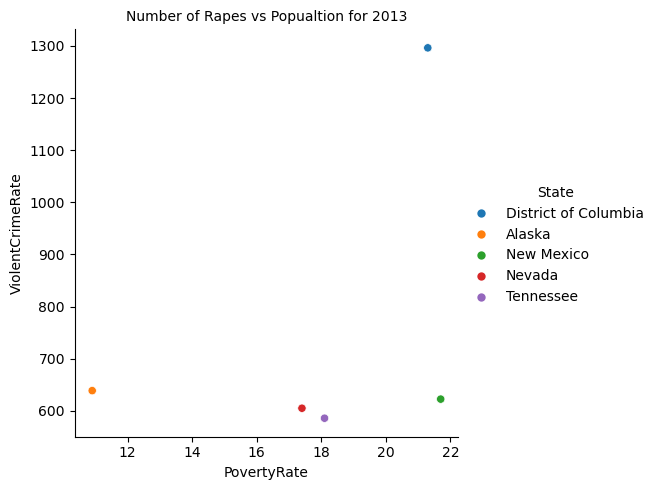

In [72]:
sns.relplot(data = poverty_crime2013, x = 'PovertyRate', y = 'ViolentCrimeRate',
            col = 'Year', hue = 'State').set_titles("Number of Rapes vs Popualtion for {col_name}");

## doing bootstrapping where each state is in its own row for each year

In [73]:
bootstrap()

TypeError: bootstrap() missing 2 required positional arguments: 'data' and 'statistic'